In [18]:
import pandas as pd 
import numpy as np
from sklearn.metrics import ndcg_score
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [19]:
def load_journal_embeddings(input_file='journal_embeddings.npz'):
    """
    Load journal embeddings from a compressed numpy file.
    
    Args:
        input_file (str): Path to the embeddings file
    
    Returns:
        dict: Dictionary mapping journal names to their embeddings
    """
    # Load the compressed file
    data = np.load(input_file, allow_pickle=True)
    
    # Reconstruct the dictionary
    journal_embeddings = {}
    for journal, embedding in zip(data['journals'], data['embeddings']):
        journal_embeddings[journal] = embedding
    
    print(f"Loaded {len(journal_embeddings)} journal embeddings")
    return journal_embeddings
def evaluate_recommendations(paper_embeddings, true_journals, journal_embeddings, k_values=[1, 3, 5, 10]):
    """
    Evaluate journal recommendations using cosine similarity
    """
    # Convert journal embeddings to matrix form
    journal_names = list(journal_embeddings.keys())
    journal_emb_matrix = np.stack([journal_embeddings[j] for j in journal_names])
    
    # Convert paper embeddings to numpy arrays if they're not already
    if isinstance(paper_embeddings[0], str):
        paper_embeddings = [string_to_array(emb) for emb in paper_embeddings]
    
    # Stack and normalize paper embeddings
    paper_embeddings = np.stack([emb for emb in paper_embeddings if emb is not None])
    paper_embeddings = paper_embeddings / np.linalg.norm(paper_embeddings, axis=1, keepdims=True)
    
    # Calculate similarities
    similarities = np.dot(paper_embeddings, journal_emb_matrix.T)
    
    # Convert to probabilities using softmax
    probabilities = F.softmax(torch.tensor(similarities) / 0.05, dim=1).numpy()  # Added temperature scaling
    
    # Create one-hot encoded ground truth
    journal_to_idx = {j: i for i, j in enumerate(journal_names)}
    true_indices = np.array([journal_to_idx[j] for j in true_journals])
    n_samples = len(true_indices)
    n_classes = len(journal_names)
    y_true = np.zeros((n_samples, n_classes))
    y_true[np.arange(n_samples), true_indices] = 1
    
    metrics = {}
    
    # Calculate metrics
    for k in k_values:
        # Top-k accuracy
        top_k_indices = np.argsort(-similarities, axis=1)[:, :k]
        correct_k = np.any(top_k_indices == true_indices.reshape(-1, 1), axis=1)
        top_k_acc = correct_k.mean()
        metrics[f'top_{k}_accuracy'] = top_k_acc
        
        # NDCG@k
        ndcg = ndcg_score(y_true, probabilities, k=k)
        metrics[f'ndcg@{k}'] = ndcg
    
    # Calculate MRR
    rankings = np.where(np.argsort(-similarities, axis=1) == true_indices.reshape(-1, 1))[1] + 1
    mrr = (1.0 / rankings).mean()
    metrics['mrr'] = mrr
    
    # Calculate MAP
    ap_sum = 0
    for i, true_idx in enumerate(true_indices):
        ranking = np.argsort(-similarities[i])
        rank = np.where(ranking == true_idx)[0][0] + 1
        ap_sum += 1.0 / rank
    metrics['map'] = ap_sum / len(true_indices)
    
    return metrics, similarities

def string_to_array(embedding_str):
    """Convert string representation of embedding to numpy array"""
    try:
        # Clean the string and split numbers
        cleaned_str = embedding_str.strip('[]').replace('\n', ' ')
        numbers = [float(x) for x in cleaned_str.split() if x]
        return np.array(numbers)
    except:
        print(f"Error processing embedding string: {embedding_str[:100]}...")
        return None

In [21]:
df = pd.read_csv('updated_dataframe.csv')
test_df = df[:5000]
# In another script
journal_embeddings = load_journal_embeddings()
# Use the embeddings for recommendations or analysis
# Evaluate on test set
print("\nEvaluating on test set...")
test_papers = test_df['embedding'].values
test_journals = test_df['journal'].values

# Calculate metrics
k_values = list(range(1, 11))
metrics, similarities = evaluate_recommendations(
    test_papers, 
    test_journals, 
    journal_embeddings, 
    k_values
)

# Print results
print("\nBenchmark Results (Average Embeddings Method):")
print("\nTop-k Accuracy:")
for k in k_values:
    print(f"Top-{k}: {metrics[f'top_{k}_accuracy']:.4f}")

print("\nNDCG Scores:")
for k in k_values:
    print(f"NDCG@{k}: {metrics[f'ndcg@{k}']:.4f}")

print(f"\nMRR: {metrics['mrr']:.4f}")
print(f"MAP: {metrics['map']:.4f}")

Loaded 66 journal embeddings

Evaluating on test set...

Benchmark Results (Average Embeddings Method):

Top-k Accuracy:
Top-1: 0.3988
Top-2: 0.5770
Top-3: 0.6832
Top-4: 0.7554
Top-5: 0.8090
Top-6: 0.8518
Top-7: 0.8764
Top-8: 0.8974
Top-9: 0.9134
Top-10: 0.9278

NDCG Scores:
NDCG@1: 0.3988
NDCG@2: 0.5112
NDCG@3: 0.5643
NDCG@4: 0.5954
NDCG@5: 0.6162
NDCG@6: 0.6314
NDCG@7: 0.6396
NDCG@8: 0.6462
NDCG@9: 0.6510
NDCG@10: 0.6552

MRR: 0.5732
MAP: 0.5732


In [22]:
df.head()

,id,title,abstract,keywords,journal,keyword_count,embedding,similar_papers,high_similarity_count,keyword_similarity_count,jaccard_similarity_count,connection_range
0,cs_1,Fighting malicious code: an eternal struggle,Despite many years of research and significant...,"Security and privacy, Intrusion/anomaly detect...",ACM Conference on Computer and Communications ...,4,[-7.15448707e-02 8.84855911e-03 -2.46604253e-...,"[('cs_17', 0.54332185), ('cs_1384', 0.5124493)...",12,84,58,10-15
1,cs_2,Letting the puss in boots sweat: detecting fak...,The only available IEEE 802.11 network identif...,"Networks, Network services, Network types, Pub...",ACM Conference on Computer and Communications ...,6,[-1.00172892e-01 2.39987839e-02 1.78415999e-...,"[('cs_24', 0.52022445), ('cs_64', 0.55415004),...",34,380,130,30-50
2,cs_3,Scanner hunter: understanding HTTP scanning tr...,This paper focuses on detecting and studying H...,Applied computing,ACM Conference on Computer and Communications ...,1,[-6.70441166e-02 3.52663756e-03 -4.61701825e-...,"[('cs_4', 0.56352115), ('cs_11', 0.59189296), ...",30,0,95,20-30
3,cs_4,Detection of stealthy malware activities with ...,Studies show that a significant portion of net...,"Security and privacy, Network security",ACM Conference on Computer and Communications ...,2,[-9.63144079e-02 2.17957748e-03 2.55297739e-...,"[('cs_3', 0.56352115), ('cs_17', 0.61029315), ...",54,25,40,30-50
4,cs_5,Re3: relay reliability reputation for anonymit...,"To conceal user identities, Tor, a popular ano...","Security and privacy, Network security",ACM Conference on Computer and Communications ...,2,[-1.16817787e-01 -1.11325048e-02 -4.36492525e-...,"[('cs_6', 0.5136872), ('cs_41', 0.5262448), ('...",56,25,40,30-50


In [26]:
print(df.iloc[1000]['abstract'])
print(df.iloc[1000]['title'])

Communication primitives such as coding and multiple antenna processing have provided significant benefits for traditional wireless systems. Existing designs, however, consume significant power and computational resources, and hence cannot be run on low complexity, power constrained backscatter devices. This paper makes two main contributions: (1) we introduce the first multi-antenna cancellation design that operates on backscatter devices while retaining a small form factor and power footprint, (2) we introduce a novel coding mechanism that enables long range communication as well as concurrent transmissions and can be decoded on backscatter devices. We build hardware prototypes of the above designs that can be powered solely using harvested energy from TV and solar sources. The results show that our designs provide benefits for both RFID and ambient backscatter systems: they enable RFID tags to communicate directly with each other at distances of tens of meters and through multiple w

In [47]:
print(df.iloc[145]['abstract'])
print(df.iloc[145]['title'])

Photos are becoming prominent means of communication online. Despite photos' pervasive presence in social media and online world, we know little about how people interact and engage with their content. Understanding how photo content might signify engagement, can impact both science and design, influencing production and distribution. One common type of photo content that is shared on social media, is the photos of people. From studies of offline behavior, we know that human faces are powerful channels of non-verbal communication. In this paper, we study this behavioral phenomena online. We ask how presence of a face, it's age and gender might impact social engagement on the photo. We use a corpus of 1 million Instagram images and organize our study around two social engagement feedback factors, likes and comments. Our results show that photos with faces are 38% more likely to receive likes and 32% more likely to receive comments, even after controlling for social network reach and act

In [27]:
print(df.iloc[2]['abstract'])
print(df.iloc[2]['title'])

This paper focuses on detecting and studying HTTP scanners, which are malicious entities that explore a website selectively for opportunities" that can potentially be used for subsequent intrusion attempts. Interestingly there is practically no prior work on the detection of these entities which are different from web crawlers or machines performing network-level reconnaissance activities such as port scanning. Detecting HTTP scanners is challenging as they are stealthy and often only probe a few key places on a website so finding them is a needle-in-the-haystack problem. At the same time they pose serious risk because they perform the first exploratory step to provide the seed information that may allow hackers to compromise a website. Our work makes two main contributions. First we propose Scanner Hunter arguably the first method to detect HTTP scanners efficiently. The novelty and success of the method lies in the use of community structure in an appropriately constructed bipartite 

### Analyzing Novelty

In [29]:

def calculate_novelty_score(paper_embedding, journal_embeddings, df, k=5):
    """
    Calculate novelty score for a paper based on its similarity to papers in top recommended journals.
    
    Args:
        paper_embedding (np.array): Embedding vector of the paper to evaluate
        journal_embeddings (dict): Dictionary of journal embeddings
        df (pd.DataFrame): DataFrame containing all papers with their embeddings
        k (int): Number of top journals to consider
    
    Returns:
        dict: Dictionary containing novelty score and category
    """
    # Convert paper embedding to numpy array if it's a string
    if isinstance(paper_embedding, str):
        paper_embedding = string_to_array(paper_embedding)
    
    # Normalize paper embedding
    paper_embedding = paper_embedding / np.linalg.norm(paper_embedding)
    
    # Get journal recommendations
    journal_names = list(journal_embeddings.keys())
    journal_emb_matrix = np.stack([journal_embeddings[j] for j in journal_names])
    similarities = np.dot(paper_embedding, journal_emb_matrix.T)
    
    # Get top k journals
    top_k_indices = np.argsort(-similarities)[:k]
    top_journals = [journal_names[idx] for idx in top_k_indices]
    
    # Get papers from top journals
    relevant_papers = df[df['journal'].isin(top_journals)]
    
    # Calculate similarities with papers in top journals
    similarities_list = []
    for _, row in relevant_papers.iterrows():
        other_embedding = string_to_array(row['embedding'])
        if other_embedding is not None:
            other_embedding = other_embedding / np.linalg.norm(other_embedding)
            similarity = np.dot(paper_embedding, other_embedding)
            similarities_list.append(similarity)
    
    # Calculate average similarity (lower means more novel)
    if similarities_list:
        avg_similarity = np.mean(similarities_list)
    else:
        avg_similarity = 0
        
    # Define novelty categories
    if avg_similarity < 0.1:
        category = "Highly Novel"
        score = 3
    elif avg_similarity < 0.2:
        category = "Novel"
        score = 2
    elif avg_similarity < 0.3:
        category = "Moderately Novel"
        score = 1
    else:
        category = "Not Novel"
        score = 0
        
    return {
        'novelty_score': score,
        'novelty_category': category,
        'average_similarity': avg_similarity,
        'top_journals': top_journals
    }

def batch_calculate_novelty(papers_df, journal_embeddings, batch_size=100):
    """
    Calculate novelty scores for a batch of papers.
    
    Args:
        papers_df (pd.DataFrame): DataFrame containing papers with embeddings
        journal_embeddings (dict): Dictionary of journal embeddings
        batch_size (int): Number of papers to process in each batch
    
    Returns:
        pd.DataFrame: Original DataFrame with novelty scores added
    """
    results = []
    
    for i in range(0, len(papers_df), batch_size):
        batch = papers_df.iloc[i:i+batch_size]
        
        for _, row in batch.iterrows():
            paper_embedding = row['embedding']
            novelty_results = calculate_novelty_score(paper_embedding, journal_embeddings, papers_df)
            
            result_dict = {
                'paper_id': row.name,
                'novelty_score': novelty_results['novelty_score'],
                'novelty_category': novelty_results['novelty_category'],
                'average_similarity': novelty_results['average_similarity'],
                'top_recommended_journals': novelty_results['top_journals']
            }
            results.append(result_dict)
            
        # Print progress
        print(f"Processed {min(i + batch_size, len(papers_df))} / {len(papers_df)} papers")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Merge with original DataFrame
    return papers_df.join(results_df.set_index('paper_id'))

# Helper function to convert string embeddings to numpy arrays
def string_to_array(embedding_str):
    """Convert string representation of embedding to numpy array"""
    try:
        cleaned_str = embedding_str.strip('[]').replace('\n', ' ')
        numbers = [float(x) for x in cleaned_str.split() if x]
        return np.array(numbers)
    except:
        print(f"Error processing embedding string: {embedding_str[:100]}...")
        return None

In [36]:

def analyze_novelty_scores(df):
    """
    Comprehensive analysis of novelty scores including visualizations and statistical summaries.
    
    Args:
        df (pd.DataFrame): DataFrame containing novelty scores and categories
    
    Returns:
        dict: Dictionary containing various analysis results
    """
    # Create figure with multiple subplots
    plt.style.use('default')  # Using default style instead of seaborn
    fig = plt.figure(figsize=(20, 15))
    
    try:
        # 1. Distribution of Novelty Categories
        plt.subplot(2, 2, 1)
        category_counts = df['novelty_category'].value_counts()
        category_percentages = (category_counts / len(df) * 100).round(2)
        
        colors = ['#2ecc71', '#3498db', '#f1c40f', '#e74c3c']
        plt.pie(category_percentages, 
                labels=[f"{cat}\n({pct}%)" for cat, pct in zip(category_counts.index, category_percentages)],
                colors=colors, 
                autopct='%1.1f%%')
        plt.title('Distribution of Novelty Categories')
        
        # 2. Distribution of Average Similarity Scores
        plt.subplot(2, 2, 2)
        sns.histplot(data=df, x='average_similarity', bins=50, kde=True)
        plt.axvline(x=0.1, color='g', linestyle='--', label='Highly Novel Threshold')
        plt.axvline(x=0.2, color='y', linestyle='--', label='Novel Threshold')
        plt.axvline(x=0.3, color='r', linestyle='--', label='Moderately Novel Threshold')
        plt.title('Distribution of Average Similarity Scores')
        plt.legend()
        
        # 3. Box Plot of Average Similarity by Journal (Top 10 journals by count)
        plt.subplot(2, 2, 3)
        top_journals = df['journal'].value_counts().nlargest(10).index
        journal_data = df[df['journal'].isin(top_journals)]
        sns.boxplot(data=journal_data, x='journal', y='average_similarity')
        plt.xticks(rotation=45, ha='right')
        plt.title('Average Similarity by Top 10 Journals')
        
        # 4. Violin Plot of Novelty Scores by Category
        plt.subplot(2, 2, 4)
        sns.violinplot(data=df, x='novelty_category', y='average_similarity')
        plt.xticks(rotation=45)
        plt.title('Distribution of Similarity Scores by Novelty Category')
        
        plt.tight_layout()
        
    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        plt.close(fig)
        return None
    
    # Statistical Analysis
    stats_dict = {
        'basic_stats': df['average_similarity'].describe(),
        'category_distribution': category_percentages,
        'journal_stats': df.groupby('journal').agg({
            'average_similarity': ['mean', 'std', 'count'],
            'novelty_score': ['mean', 'std']
        }).round(4)
    }
    
    # Correlation Analysis
    correlations = {}
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if col != 'average_similarity' and col != 'novelty_score':
            correlation = df['average_similarity'].corr(df[col])
            correlations[col] = correlation
    
    stats_dict['correlations'] = correlations
    
    # Time Trends (if date column exists)
    if 'date' in df.columns:
        try:
            df['year'] = pd.to_datetime(df['date']).dt.year
            stats_dict['yearly_trends'] = df.groupby('year')['novelty_score'].mean()
        except Exception as e:
            print(f"Error processing date column: {str(e)}")
    
    return stats_dict

def analyze_novelty_by_field(df, field_column):
    """
    Analyze novelty patterns across different fields or categories.
    
    Args:
        df (pd.DataFrame): DataFrame containing novelty scores
        field_column (str): Name of the column containing field/category information
    """
    if field_column not in df.columns:
        raise ValueError(f"Column '{field_column}' not found in DataFrame")
        
    # Create figure
    plt.figure(figsize=(15, 10))
    
    try:
        # 1. Average novelty score by field
        plt.subplot(2, 2, 1)
        field_avg = df.groupby(field_column)['novelty_score'].mean().sort_values(ascending=True)
        field_avg.plot(kind='barh')
        plt.title(f'Average Novelty Score by {field_column}')
        
        # 2. Distribution of novelty categories within each field
        plt.subplot(2, 2, 2)
        category_by_field = pd.crosstab(df[field_column], df['novelty_category'], normalize='index') * 100
        category_by_field.plot(kind='bar', stacked=True)
        plt.title(f'Distribution of Novelty Categories by {field_column}')
        plt.legend(title='Novelty Category', bbox_to_anchor=(1.05, 1))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        
    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        plt.close()
        return None
    
    # Statistical tests
    try:
        # Chi-square test
        contingency_table = pd.crosstab(df[field_column], df['novelty_category'])
        chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
        
        # ANOVA test
        fields = df[field_column].unique()
        similarity_by_field = [df[df[field_column] == field]['average_similarity'] for field in fields]
        f_stat, anova_p = stats.f_oneway(*similarity_by_field)
        
        return {
            'field_averages': field_avg,
            'category_distribution': category_by_field,
            'chi2_test': {'statistic': chi2, 'p_value': p_value},
            'anova_test': {'f_statistic': f_stat, 'p_value': anova_p}
        }
        
    except Exception as e:
        print(f"Error in statistical analysis: {str(e)}")
        return None

def generate_summary_report(df):
    """
    Generate a comprehensive summary report of novelty analysis.
    
    Args:
        df (pd.DataFrame): DataFrame containing novelty scores and categories
    
    Returns:
        str: Formatted summary report
    """
    try:
        # Calculate key metrics
        total_papers = len(df)
        highly_novel = (df['novelty_category'] == 'Highly Novel').sum()
        avg_similarity = df['average_similarity'].mean()
        
        # Generate report
        report = f"""
        Novelty Analysis Summary Report
        ==============================
        
        Overview:
        ---------
        Total Papers Analyzed: {total_papers:,}
        Highly Novel Papers: {highly_novel:,} ({(highly_novel/total_papers)*100:.1f}%)
        Average Similarity Score: {avg_similarity:.3f}
        
        Novelty Category Distribution:
        ----------------------------
        """
        
        for category, count in df['novelty_category'].value_counts().items():
            percentage = (count/total_papers)*100
            report += f"{category}: {count:,} papers ({percentage:.1f}%)\n"
        
        # Add journal-specific analysis
        report += "\nTop Journals by Average Novelty:\n"
        report += "--------------------------------\n"
        journal_stats = df.groupby('journal').agg({
            'novelty_score': ['mean', 'count']
        }).sort_values(('novelty_score', 'mean'), ascending=False)
        
        for journal in journal_stats.head(10).index:
            mean_score = journal_stats.loc[journal, ('novelty_score', 'mean')]
            count = journal_stats.loc[journal, ('novelty_score', 'count')]
            report += f"{journal}: {mean_score:.3f} (n={count:,})\n"
        
        return report
        
    except Exception as e:
        return f"Error generating report: {str(e)}"

In [39]:
test_df=df[:10000]
# First calculate novelty scores if you haven't already
test_df_with_novelty = batch_calculate_novelty(test_df, journal_embeddings)

Processed 100 / 10000 papers
Processed 200 / 10000 papers
Processed 300 / 10000 papers
Processed 400 / 10000 papers
Processed 500 / 10000 papers
Processed 600 / 10000 papers
Processed 700 / 10000 papers
Processed 800 / 10000 papers
Processed 900 / 10000 papers
Processed 1000 / 10000 papers
Processed 1100 / 10000 papers
Processed 1200 / 10000 papers
Processed 1300 / 10000 papers
Processed 1400 / 10000 papers
Processed 1500 / 10000 papers
Processed 1600 / 10000 papers
Processed 1700 / 10000 papers
Processed 1800 / 10000 papers
Processed 1900 / 10000 papers
Processed 2000 / 10000 papers
Processed 2100 / 10000 papers
Processed 2200 / 10000 papers
Processed 2300 / 10000 papers
Processed 2400 / 10000 papers
Processed 2500 / 10000 papers
Processed 2600 / 10000 papers
Processed 2700 / 10000 papers
Processed 2800 / 10000 papers
Processed 2900 / 10000 papers
Processed 3000 / 10000 papers
Processed 3100 / 10000 papers
Processed 3200 / 10000 papers
Processed 3300 / 10000 papers
Processed 3400 / 10


=== Novelty Score Analysis ===

1. Basic Statistics for Average Similarity:
count    10000.000000
mean         0.239610
std          0.055664
min          0.018346
25%          0.204111
50%          0.239887
75%          0.275402
max          0.436380
Name: average_similarity, dtype: float64

2. Distribution of Novelty Categories:
Moderately Novel: 64.05%
Novel: 21.72%
Not Novel: 13.24%
Highly Novel: 0.99%

3. Journal Statistics (Top 10 by count):
                                                   average_similarity          \
                                                                 mean     std   
journal                                                                         
ACM Conference on Human Factors in Computing Sy...             0.2028  0.0382   
AAAI Conference on Artificial Intelligence                     0.2048  0.0437   
IEEE Transactions on Parallel and Distributed S...             0.2502  0.0492   
IEEE International Conference on Computer Commu...           

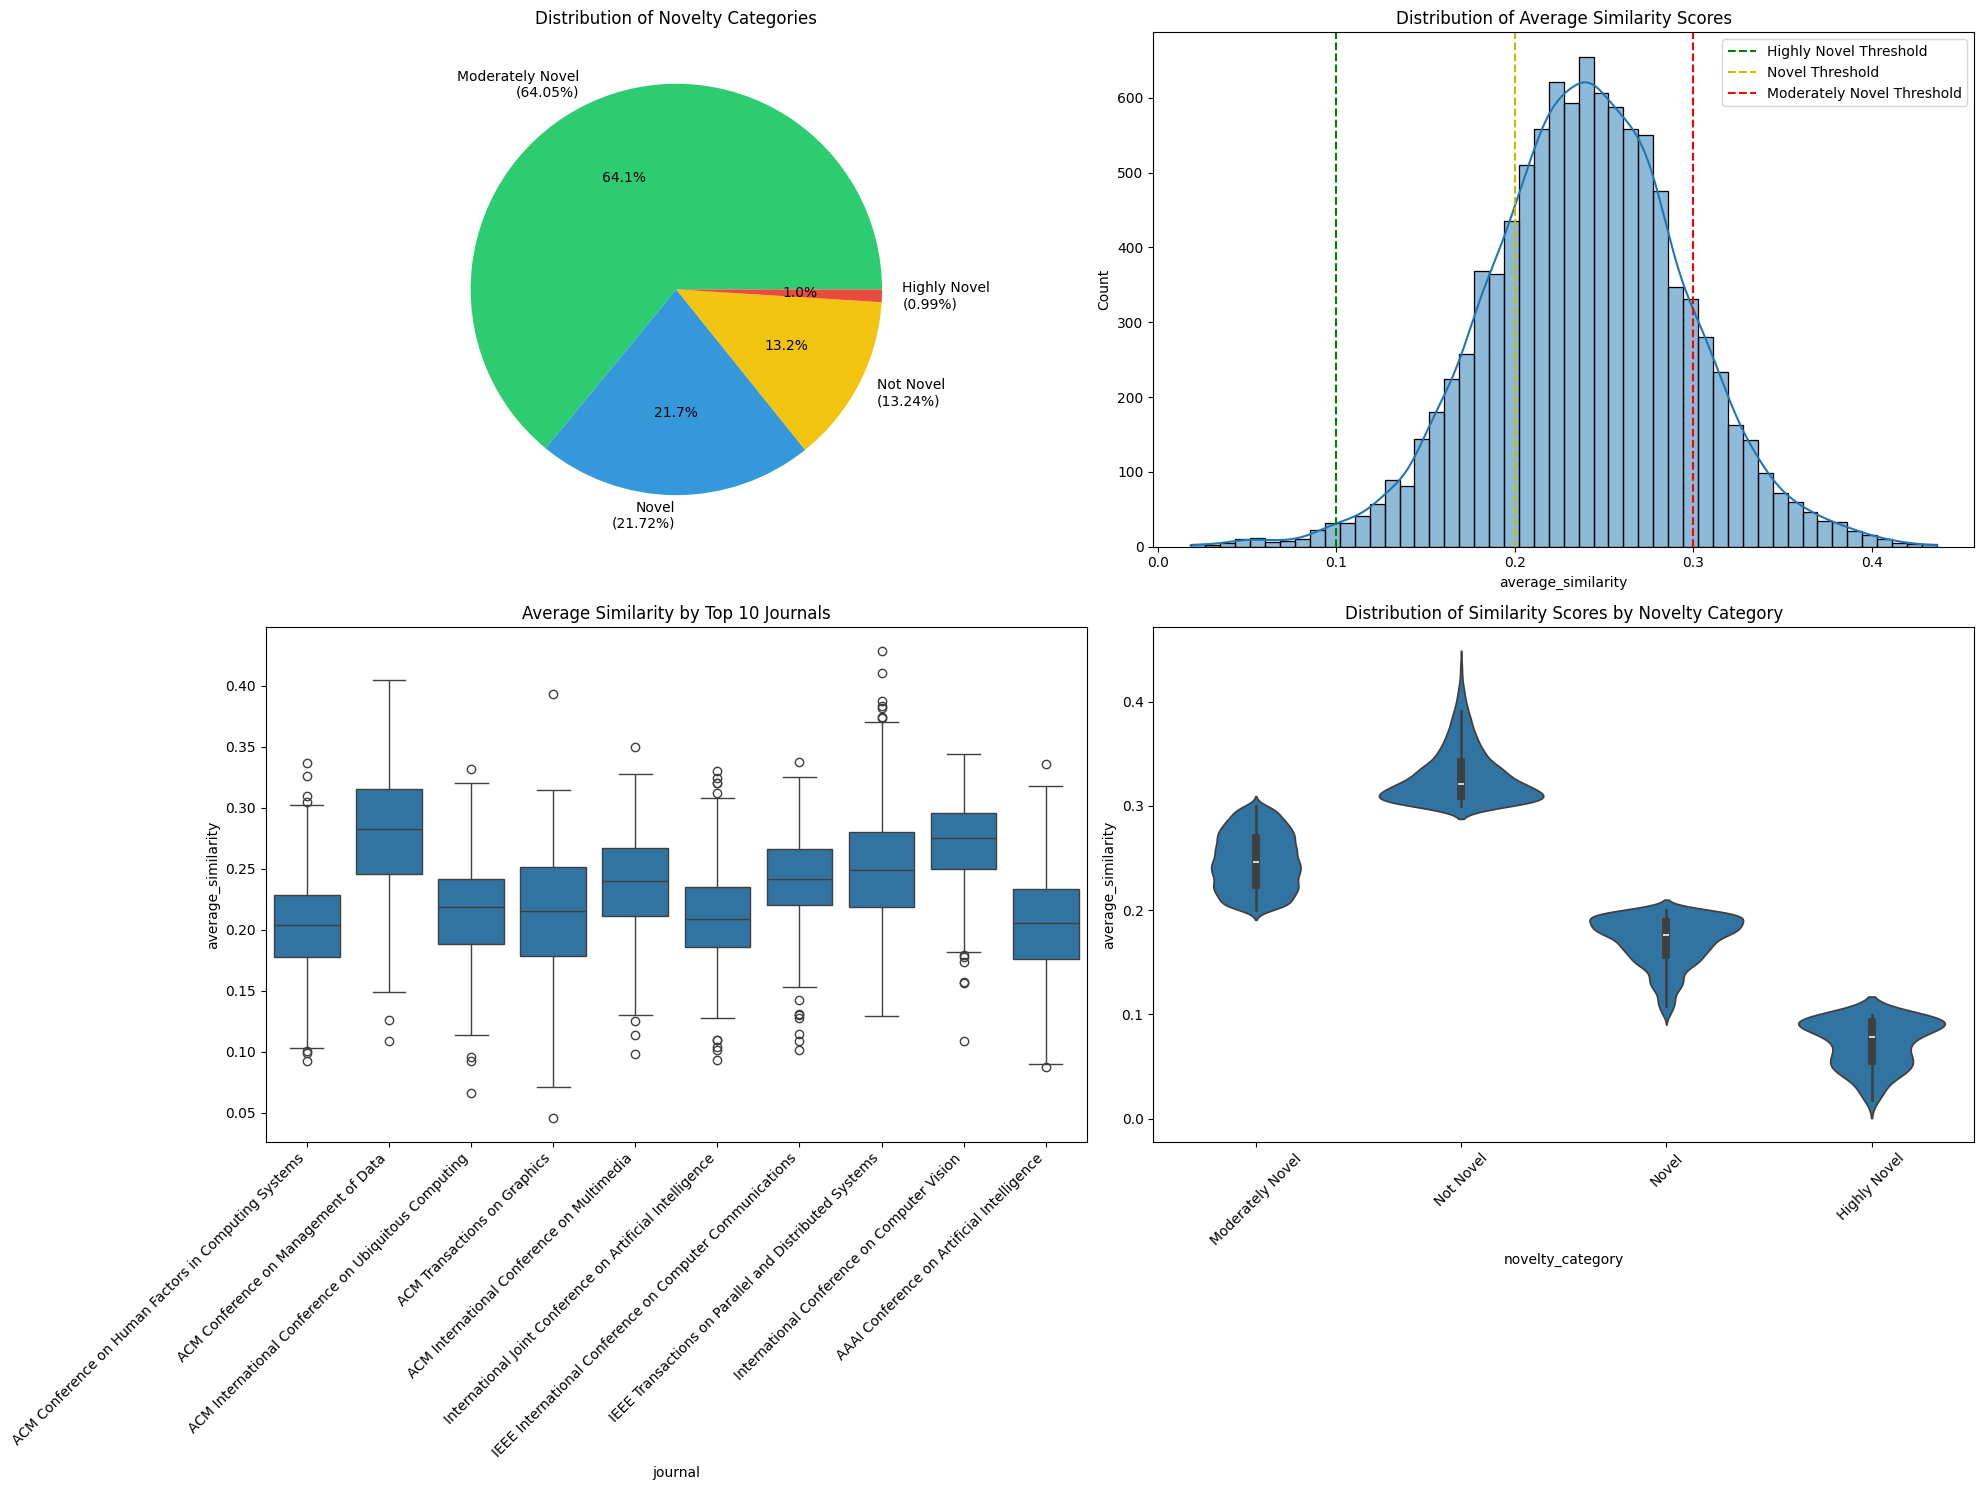

In [40]:



# Run the comprehensive analysis
results = analyze_novelty_scores(test_df_with_novelty)
print_analysis_results(results)

# # If you have a field/category column (e.g., 'subject_area')
# field_analysis = analyze_novelty_by_field(test_df_with_novelty, 'journal')

# Generate a summary report
report = generate_summary_report(test_df_with_novelty)
print(report)

In [ ]:
# Current thresholds are at 0.1, 0.2, and 0.3


# Breakthrough Research (formerly Highly Novel): < 0.15
# Innovative Research (formerly Novel): 0.15 - 0.22
# Incremental Advance (formerly Moderately Novel): 0.22 - 0.28
# Confirmatory Research (formerly Not Novel): > 0.28


# Rationale:

# 0.15: There's a clear increase in density after this point, capturing true outliers
# 0.22: This is near the peak of the distribution, marking a natural transition point
# 0.28: This captures the right tail of the main distribution

In [44]:
def update_novelty_categories(df):
    """
    Update novelty categories with new names and thresholds based on average_similarity scores.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'average_similarity' and 'novelty_category' columns
    
    Returns:
        pd.DataFrame: DataFrame with updated novelty categories
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_updated = df.copy()
    
    # Define new category based on updated thresholds
    conditions = [
        (df_updated['average_similarity'] < 0.15),
        (df_updated['average_similarity'] >= 0.15) & (df_updated['average_similarity'] < 0.22),
        (df_updated['average_similarity'] >= 0.22) & (df_updated['average_similarity'] < 0.28),
        (df_updated['average_similarity'] >= 0.28)
    ]
    
    choices = [
        'Possibility of a Breakthrough Research',
        'Considerable Good Innovative Research',
        'Moderately Novel',
        'Not Innovative- Too much Existing Literature Already'
    ]
    
    # Apply new categories
    df_updated['novelty_category'] = np.select(conditions, choices, default='Uncategorized')
    
    # Print distribution of new categories
    print("\nNew Category Distribution:")
    dist = df_updated['novelty_category'].value_counts(normalize=True).round(4) * 100
    for category, percentage in dist.items():
        print(f"{category}: {percentage:.2f}%")
    
    return df_updated

# Usage:
df_new = update_novelty_categories(test_df_with_novelty)


New Category Distribution:
Moderately Novel: 42.51%
Considerable Good Innovative Research: 30.16%
Not Innovative- Too much Existing Literature Already: 22.25%
Possibility of a Breakthrough Research: 5.08%



=== Novelty Score Analysis ===

1. Basic Statistics for Average Similarity:
count    10000.000000
mean         0.239610
std          0.055664
min          0.018346
25%          0.204111
50%          0.239887
75%          0.275402
max          0.436380
Name: average_similarity, dtype: float64

2. Distribution of Novelty Categories:
Moderately Novel: 42.51%
Considerable Good Innovative Research: 30.16%
Not Innovative- Too much Existing Literature Already: 22.25%
Possibility of a Breakthrough Research: 5.08%

3. Journal Statistics (Top 10 by count):
                                                   average_similarity          \
                                                                 mean     std   
journal                                                                         
ACM Conference on Human Factors in Computing Sy...             0.2028  0.0382   
AAAI Conference on Artificial Intelligence                     0.2048  0.0437   
IEEE Transactions on Parallel and Distrib

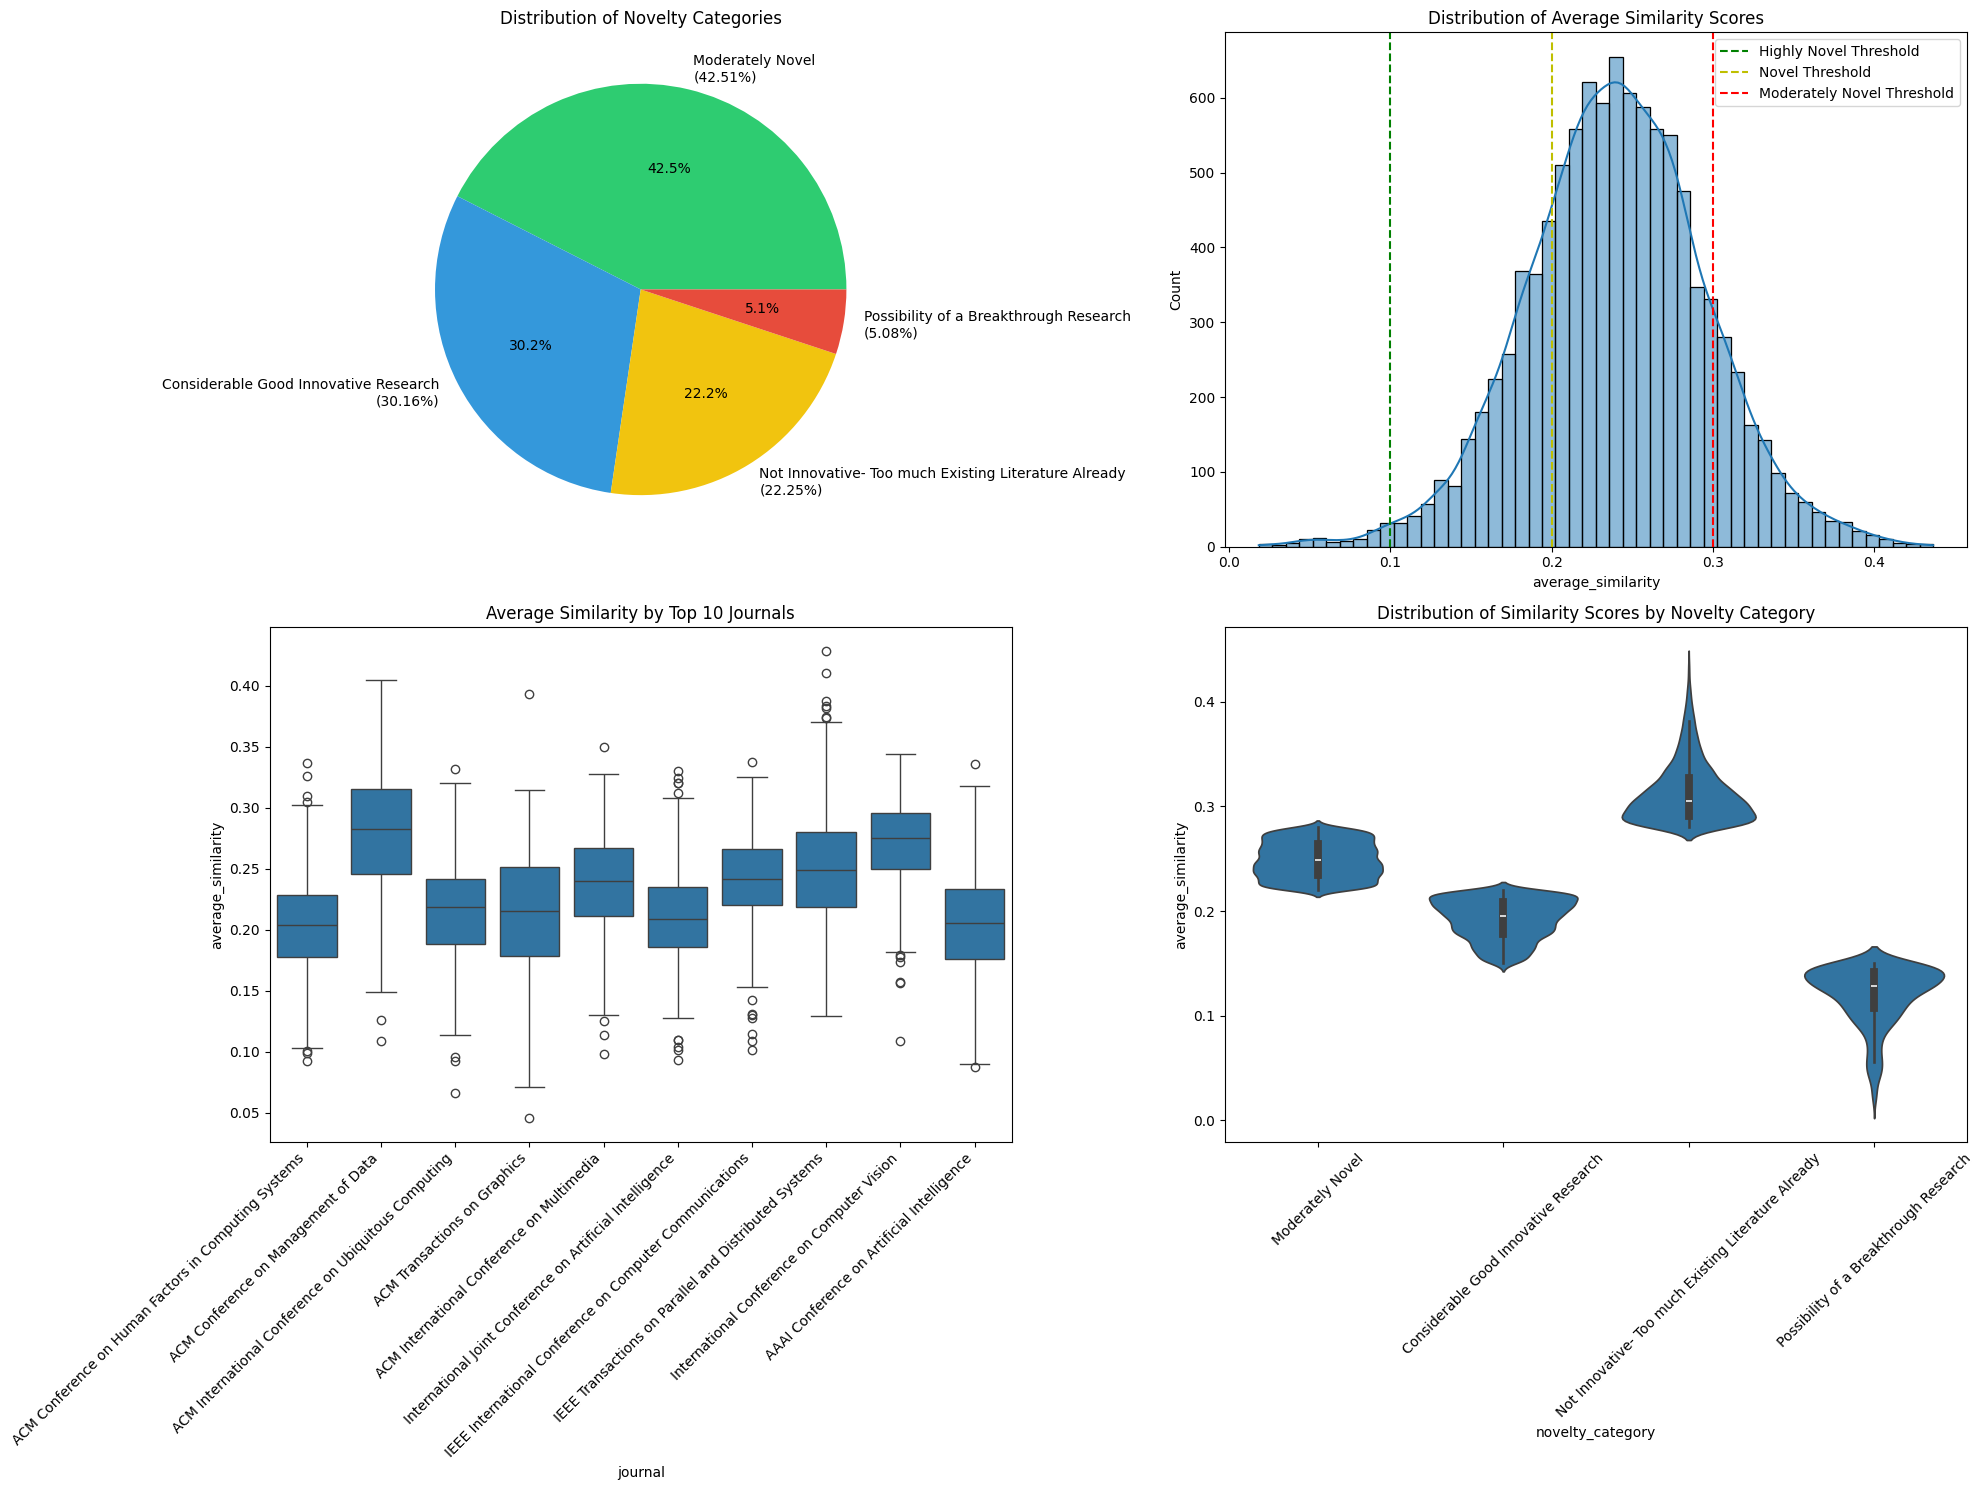

In [45]:
# Run the comprehensive analysis
results = analyze_novelty_scores(df_new)
print_analysis_results(results)

# # If you have a field/category column (e.g., 'subject_area')
# field_analysis = analyze_novelty_by_field(df_new, 'journal')

# Generate a summary report
report = generate_summary_report(df_new)
print(report)